In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
matplotlib.rcParams['figure.figsize'] = 10, 4 
plt.style.use('tableau-colorblind10')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
#pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
#matplotlib.rcParams.update(pgf_with_rc_fonts)
sns.set_palette(['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'])

In [3]:
df = pd.read_csv('../data/cleaned/cleaned_flood_data.csv')

df.head()

,begin_date,end_date,season,fips,parish,region,event_type,begin_lat,begin_lon,end_lat,...,deaths_direct,deaths_indirect,damage_property,awnd,prcp,tmax,tmin,wsf2,wsf5,prev_7d_prcp
0,2017-10-21,2017-10-21,fall,22085,Sabine,Northwest,None,31.78,-93.70,31.78,...,0.0,0.0,0.0,4.47,0.045,82.5,62.5,12.1,18.1,0.015
1,2001-04-03,2001-04-03,spring,22055,Lafayette,Southwest,None,30.23,-92.18,30.23,...,0.0,0.0,0.0,10.29,0.000,83.0,71.0,19.9,23.0,3.140
2,1997-12-14,1997-12-14,winter,22017,Caddo,Northwest,None,32.48,-93.75,32.48,...,0.0,0.0,0.0,3.80,0.000,54.0,27.0,14.1,16.1,1.100
3,2013-01-15,2013-01-15,winter,22045,Iberia,Southwest,None,30.03,-91.88,30.03,...,0.0,0.0,0.0,11.63,0.630,46.0,39.0,17.9,23.9,9.740
4,2002-11-22,2002-11-22,fall,22033,East Baton Rouge,Southeast,None,30.47,-91.17,30.47,...,0.0,0.0,0.0,6.04,0.000,64.5,43.5,14.1,17.9,1.160


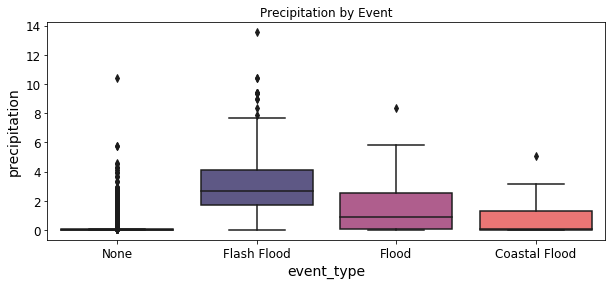

In [4]:
sns.boxplot(x='event_type', y='prcp', data=df)
plt.ylabel('precipitation')
plt.title('Precipitation by Event')
plt.savefig('../docs/img/precip_box.png', dpi=300, bbox_inches='tight');

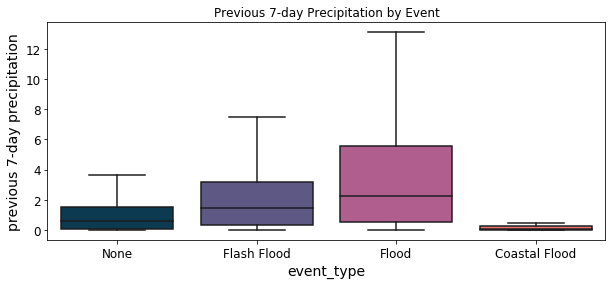

In [5]:
sns.boxplot(x='event_type', y='prev_7d_prcp', data=df, showfliers=False)
plt.ylabel('previous 7-day precipitation')
plt.title('Previous 7-day Precipitation by Event')
plt.savefig('../docs/img/precip_7d_box.png', dpi=300, bbox_inches='tight');

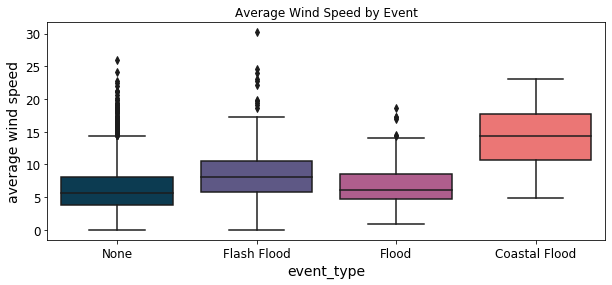

In [6]:
sns.boxplot(x='event_type', y='awnd', data=df)
plt.ylabel('average wind speed')
plt.title('Average Wind Speed by Event')
plt.savefig('../docs/img/wind.png', dpi=300, bbox_inches='tight');

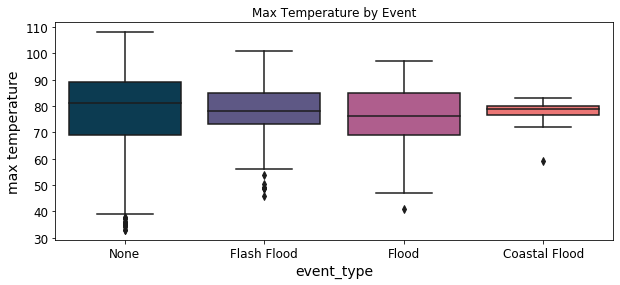

In [7]:
sns.boxplot(x='event_type', y='tmax', data=df)
plt.ylabel('max temperature')
plt.title('Max Temperature by Event')
plt.savefig('../docs/img/max_temp.png', dpi=300, bbox_inches='tight');

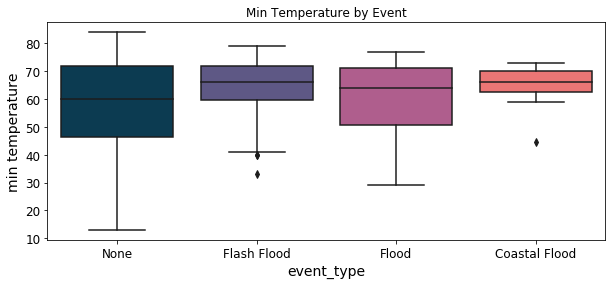

In [8]:
sns.boxplot(x='event_type', y='tmin', data=df)
plt.ylabel('min temperature')
plt.title('Min Temperature by Event')
plt.savefig('../docs/img/min_temp.png', dpi=300, bbox_inches='tight');

In [9]:
test = pd.get_dummies(df, columns=['region', 'season', 'event_type'])
corr = test.loc[:, 'awnd':'event_type_None'].corr()

In [10]:
regions = ['region_Central', 'region_Northeast', 'region_Northwest', 'region_Southeast',
          'region_Southwest']
seasons = ['season_fall', 'season_spring', 'season_summer', 'season_winter']
events = ['event_type_Coastal Flood', 'event_type_Flash Flood', 'event_type_Flood',
         'event_type_None']
mets = ['awnd', 'prcp', 'tmax', 'tmin', 'wsf2', 'wsf5', 'prev_7d_prcp']

In [11]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


for e in events:
    for s in seasons:
        c_v = cramers_v(test[e], test[s])
        corr.loc[e, s] = c_v
        corr.loc[s, e] = c_v
    for r in regions:
        c_v = cramers_v(test[e], test[r])
        corr.loc[e, r] = c_v
        corr.loc[r, e] = c_v

In [12]:
for m in mets:
    for e in events:
        pointbiserial = ss.pointbiserialr(test[e], test[m])[0]
        corr.loc[m, e] = pointbiserial
        corr.loc[e, m] = pointbiserial
    for r in regions:
        pointbiserial = ss.pointbiserialr(test[r], test[m])[0]
        corr.loc[m, r] = pointbiserial
        corr.loc[r, m] = pointbiserial
    for s in seasons:
        pointbiserial = ss.pointbiserialr(test[s], test[m])[0]
        corr.loc[m, s] = pointbiserial
        corr.loc[s, m] = pointbiserial

In [13]:
for s in seasons:
    for r in regions:
        corr.loc[s, r] = np.nan
        corr.loc[r, s] = np.nan
    for s2 in seasons:
        corr.loc[s, s2] = np.nan
        corr.loc[s2, s] = np.nan

for r in regions:
    for r2 in regions:
        corr.loc[r, r2] = np.nan
        corr.loc[r2, r] = np.nan
        
for e in events:
    for e2 in events:
        corr.loc[e, e2] = np.nan
        corr.loc[e2, e] = np.nan

In [14]:
corr = round(corr, 2)

In [15]:
# rename to easily understandable features for figure
cols = ['avg_wind_spd', 'prcp', 'max_temp', 'min_temp',
        "fastest_2m_wind_spd", "fastest_5s_wind_spd",
        'prev_7d_prcp', 'region_Central', 'region_Northeast', 
        'region_Northwest', 'region_Southeast', 'region_Southwest',
        'season_fall', 'season_spring', 'season_summer', 'season_winter',
        'event_type_Coastal_Flood', 'event_type_Flash_Flood',
        'event_type_Flood', 'event_type_None']
corr.columns = cols
corr.index = cols

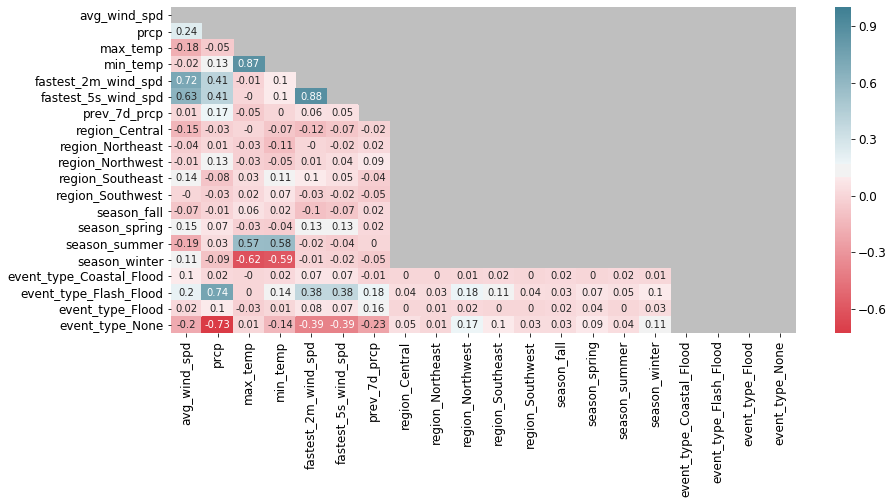

In [16]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(corr, cmap=cmap, annot=True, mask=mask)
ax.set_facecolor('#BFBFBF')
plt.savefig('../docs/img/corr_matrix.png', dpi=300, bbox_inches='tight');

In [17]:
df.event_type.value_counts()

None             4986
Flash Flood       668
Flood             132
Coastal Flood      11
Name: event_type, dtype: int64

## Inferential Statistics

In [19]:
all_arrays = {}
features = ['prcp', 'prev_7d_prcp', 
            'tmax', 'tmin', 
            'awnd',
            'wsf2', 'wsf5']

# create arrays for each feature
for feature in features:
    subset = df[['event_type', feature]]
    tuples = [tuple(x) for x in subset.values]
    data = np.rec.array(tuples,
                       dtype=[('event_type','<U13'),(feature, '<f8')])
    all_arrays[feature] = data

In [20]:
# dict for ANOVA f value and p value for each feature
anova_dict = {}
for feature in features:
    data = all_arrays[feature]
    f, p = ss.f_oneway(data[data['event_type'] == 'None'][feature],
                     data[data['event_type'] == 'Flood'][feature],
                     data[data['event_type'] == 'Flash Flood'][feature],
                     data[data['event_type'] == 'Coastal Flood'][feature])
    anova_dict[feature] = (f, p)

In [21]:
# precipitation
f = anova_dict['prcp'][0]
p = anova_dict['prcp'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['prcp']
mc = MultiComparison(data['prcp'], data['event_type'])
result = mc.tukeyhsd() 

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 2565.982533852087
p value: 0.0 

    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1       group2   meandiff  lower   upper  reject
---------------------------------------------------------
Coastal Flood Flash Flood  2.0288   1.3938  2.6638  True 
Coastal Flood    Flood     0.3071  -0.3485  0.9627 False 
Coastal Flood     None    -0.8823  -1.5129 -0.2517  True 
 Flash Flood     Flood    -1.7217  -1.9207 -1.5227  True 
 Flash Flood      None    -2.9111  -2.9972  -2.825  True 
    Flood         None    -1.1894  -1.3736 -1.0051  True 
---------------------------------------------------------
['Coastal Flood' 'Flash Flood' 'Flood' 'None']


In [22]:
# prev 7 day precipitation
f = anova_dict['prev_7d_prcp'][0]
p = anova_dict['prev_7d_prcp'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['prev_7d_prcp']
mc = MultiComparison(data['prev_7d_prcp'], data['event_type'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 125.7830795117991
p value: 6.247455103246171e-79 

    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1       group2   meandiff  lower   upper  reject
---------------------------------------------------------
Coastal Flood Flash Flood  3.6349  -0.0409  7.3106 False 
Coastal Flood    Flood     6.4031   2.6084 10.1978  True 
Coastal Flood     None     0.7947  -2.8551  4.4446 False 
 Flash Flood     Flood     2.7682   1.6164   3.92   True 
 Flash Flood      None    -2.8401  -3.3383 -2.3419  True 
    Flood         None    -5.6083  -6.6746  -4.542  True 
---------------------------------------------------------
['Coastal Flood' 'Flash Flood' 'Flood' 'None']


In [27]:
# max temperature
f = anova_dict['tmax'][0]
p = anova_dict['tmax'][1]
 
print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'P value: {p} \n')

One-way ANOVA
F value: 2.1156608044363097
P value: 0.09601967600483957 



In [29]:
# minimum temperature
f = anova_dict['tmin'][0]
p = anova_dict['tmin'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['tmin']
mc = MultiComparison(data['tmin'], data['event_type'])
result = mc.tukeyhsd()

print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 42.28166631799202
p value: 5.0756986363580016e-27 

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1       group2   meandiff  lower    upper  reject
----------------------------------------------------------
Coastal Flood Flash Flood  0.0482  -10.9785 11.0749 False 
Coastal Flood    Flood    -4.6136  -15.9972  6.7699 False 
Coastal Flood     None    -6.4375  -17.3866  4.5115 False 
 Flash Flood     Flood    -4.6619   -8.117  -1.2067  True 
 Flash Flood      None    -6.4858  -7.9803  -4.9912  True 
    Flood         None    -1.8239  -5.0227   1.3749 False 
----------------------------------------------------------
['Coastal Flood' 'Flash Flood' 'Flood' 'None']


In [30]:
# average wind speed
f = anova_dict['awnd'][0]
p = anova_dict['awnd'][1]

print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['awnd']
mc = MultiComparison(data['awnd'], data['event_type'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 102.07319647553832
p value: 2.1796511987220625e-64 

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1       group2   meandiff  lower    upper  reject
----------------------------------------------------------
Coastal Flood Flash Flood -5.7377   -8.407  -3.0684  True 
Coastal Flood    Flood    -7.2192  -9.9749  -4.4634  True 
Coastal Flood     None    -7.9559  -10.6064 -5.3053  True 
 Flash Flood     Flood    -1.4815  -2.3179  -0.6451  True 
 Flash Flood      None    -2.2182   -2.58   -1.8564  True 
    Flood         None    -0.7367  -1.5111   0.0376 False 
----------------------------------------------------------
['Coastal Flood' 'Flash Flood' 'Flood' 'None']


In [32]:
# fastest 2 min wind speed
f = anova_dict['wsf2'][0]
p = anova_dict['wsf2'][1]
 
print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['wsf2']
mc = MultiComparison(data['wsf2'], data['event_type'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 368.9129281886453
p value: 2.8691146540955695e-219 

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1       group2   meandiff  lower    upper  reject
----------------------------------------------------------
Coastal Flood Flash Flood -2.8282  -7.3235   1.6672 False 
Coastal Flood    Flood    -6.3597  -11.0006 -1.7188  True 
Coastal Flood     None    -10.4633 -14.9271 -5.9996  True 
 Flash Flood     Flood    -3.5316  -4.9402   -2.123  True 
 Flash Flood      None    -7.6352  -8.2445  -7.0259  True 
    Flood         None    -4.1036  -5.4077  -2.7995  True 
----------------------------------------------------------
['Coastal Flood' 'Flash Flood' 'Flood' 'None']


In [33]:
# fastest 5 sec wind speed
f = anova_dict['wsf5'][0]
p = anova_dict['wsf5'][1]
 
print ('One-way ANOVA')
print ('=============')
print (f'F value: {f}')
print (f'p value: {p} \n')

data = all_arrays['wsf5']
mc = MultiComparison(data['wsf5'], data['event_type'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 361.68819939873185
p value: 2.5817750543821653e-215 

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1       group2   meandiff  lower    upper  reject
----------------------------------------------------------
Coastal Flood Flash Flood -5.4298  -11.6212  0.7616 False 
Coastal Flood    Flood    -10.4211 -16.8129 -4.0293  True 
Coastal Flood     None    -15.8212 -21.969  -9.6734  True 
 Flash Flood     Flood    -4.9913  -6.9313  -3.0512  True 
 Flash Flood      None    -10.3914 -11.2306 -9.5522  True 
    Flood         None    -5.4001  -7.1962   -3.604  True 
----------------------------------------------------------
['Coastal Flood' 'Flash Flood' 'Flood' 'None']


In [45]:
cols = test.columns.tolist()[:13] + cols
test.columns = cols

In [48]:
test.to_csv('../data/cleaned/final_data.csv', index=False)